In [1]:
import pandas as pd
import json
import re
from retrying import retry
from openai import OpenAI
from tqdm import tqdm
import jsonlines
import os
import warnings
warnings.filterwarnings('ignore')

In [8]:
df2 = pd.read_csv("")
df2.columns

Index(['id', 'golden', 'resp_7b-longqlora-axun', 'resp_7b-longlora-buran',
       'resp_gpt35', 'resp_gpt4-1106', 'ordered_golden',
       'ordered_7b-longqlora-axun', 'ordered_7b-longlora-buran',
       'ordered_gpt35', 'ordered_gpt4-1106', 'num_items_golden',
       'num_items_7b-longqlora-axun', 'num_items_7b-longlora-buran',
       'num_items_gpt35', 'num_items_gpt4-1106', 'matching_7b-longqlora-axun',
       'matching_7b-longlora-buran', 'matching_gpt35', 'matching_gpt4-1106',
       'hit_7b-longqlora-axun', 'hit_7b-longlora-buran', 'hit_gpt35',
       'hit_gpt4-1106', 'rate_7b-longqlora-axun', 'rate_7b-longlora-buran',
       'rate_gpt35', 'rate_gpt4-1106', 'resp_gpt35-ft-1pct',
       'num_items_gpt35-ft-1pct', 'ordered_gpt35-ft-1pct',
       'matching_gpt35-ft-1pct', 'hit_gpt35-ft-1pct', 'rate_gpt35-ft-1pct',
       'resp_7b-longlora-ali', 'num_items_7b-longlora-ali',
       'ordered_7b-longlora-ali', 'matching_7b-longlora-ali',
       'hit_7b-longlora-ali', 'rate_7b-longlora-a

In [8]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

def draw_stacked_bar(data, save_name, color_ids):
    labels = list(data.keys())
    values = list(data.values())

    sns.set(style='whitegrid')
    fig, ax = plt.subplots()
    
    ax.barh(0, values[0], color=color_ids[0], label=labels[0])
    ax.barh(0, values[1], left=values[0], color=color_ids[1], label=labels[1])
    ax.barh(0, values[2], left=values[0]+values[1], color=color_ids[2], label=labels[2])

    ax.set_yticks([0])
    ax.set_yticklabels([''], rotation='vertical')
    ax.set_xticks(range(0, 101, 10))
    ax.set_xlabel('Win Rate')

    ax.legend()

#     ax.annotate(f'{values[0]} %', xy=(values[0] / 2, 0), ha='center', va='center', fontsize=12, color='white')
#     ax.annotate(f'{values[1]} %', xy=(values[0] + values[1] / 2, 0), ha='center', va='center', fontsize=12, color='white')
    ax.annotate('{:.2f}%'.format(values[0]), xy=(values[0] / 2, 0), ha='center', va='center', fontsize=11, color='black')
    ax.annotate('{:.2f}%'.format(values[1]), xy=(values[0] + values[1] / 2, 0), ha='center', va='center', fontsize=11, color='black')
    ax.annotate('{:.2f}%'.format(values[2]), xy=(values[0] + values[1] + values[2] / 1.5, 0), ha='center', va='center', fontsize=11, color='black')
    
    plt.title(save_name)
    sns.despine(left=True, bottom=True)  # 去除边框线
    plt.show()
    fig.savefig('{}.png'.format(save_name), dpi=300)

In [9]:
def calculating(anchor, others, dataframe, mapping, mode="nums"):
    # anchor为dataframe中模型名称，为待评估模型"llama2-7b-longlora"
    # others为列表，为一系列需用作比对胜率的模型的名称列表，如["llama2-7b-longqlora", "gpt35", "gpt4"]
    # mode为nums时统计命中数胜率，mode为rate时统计命中率胜率
    mapping = mapping
    
    assert mode in ["nums", "rate"], "mode必须为nums或rate其一。"
    
    for o in others:
        if mode == "nums":
            anchor_nums = dataframe.groupby(by=["id"])[["hit_{}".format(anchor), "hit_{}".format(o)]].agg(["mean"])["hit_{}".format(anchor)]["mean"]
            o_nums = dataframe.groupby(by=["id"])[["hit_{}".format(anchor), "hit_{}".format(o)]].agg(["mean"])["hit_{}".format(o)]["mean"]
            total_nums = dataframe.groupby(by=["id"])[["hit_{}".format(anchor), "hit_{}".format(o)]].agg(["mean"]).shape[0]
            
            wins = sum(anchor_nums > o_nums)
            win_rate = wins / total_nums
            ties = sum(anchor_nums == o_nums)
            tie_rate = ties / total_nums
        elif mode == "rate":
            anchor_nums = dataframe.groupby(by=["id"])["rate_{}".format(anchor), "rate_{}".format(o)].agg(["mean"])["rate_{}".format(anchor)]["mean"]
            o_nums = dataframe.groupby(by=["id"])["rate_{}".format(anchor), "rate_{}".format(o)].agg(["mean"])["rate_{}".format(o)]["mean"]
            total_nums = dataframe.groupby(by=["id"])["rate_{}".format(anchor), "rate_{}".format(o)].agg(["mean"]).shape[0]
            
            wins = sum(anchor_nums > o_nums)
            win_rate = wins / total_nums
            ties = sum(anchor_nums == o_nums)
            tie_rate = ties / total_nums
            
        print("{} vs. {}: 获胜数为{}，胜率为{}。".format(anchor, o, wins, win_rate))
        print("{} vs. {}: 平局数为{}，平局率为{}。".format(anchor, o, ties, tie_rate))
        print()
        
        data_dict = {
            mapping[anchor][0]: win_rate*100,
            "tie": tie_rate*100,
            mapping[o][0]: (1-win_rate-tie_rate)*100
        }
        draw_stacked_bar(data_dict, 
                         save_name="{}_vs_{}".format(mapping[anchor][0], mapping[o][0]),
                         color_ids=[mapping[anchor][1], sns.color_palette()[0],mapping[o][1]]
                         )
        
    return

In [10]:
mapping = {
        "8x7b-mixtral-jiasiding": ["8x7b-mixtral-jiasiding", sns.color_palette()[7]],
        "7b-gemma-ali": ["7b-gemma-ali", sns.color_palette()[6]],
        "7b-longqlora-axun": ["7b-longqlora-axun", sns.color_palette()[3]],
        "13b-longqlora-axun": ["13b-longqlora-axun(fp16)", sns.color_palette()[4]],
        "gpt35-ft-1pct": ["gpt-3.5-turbo-ft-1pct", sns.color_palette()[5]],
        "gpt35": ["gpt-3.5-turbo", sns.color_palette()[1]],
        "gpt4-1106": ["gpt-4-1106", sns.color_palette()[2]]
    }

8x7b-mixtral-jiasiding vs. 7b-gemma-ali: 获胜数为26，胜率为0.45614035087719296。
8x7b-mixtral-jiasiding vs. 7b-gemma-ali: 平局数为4，平局率为0.07017543859649122。



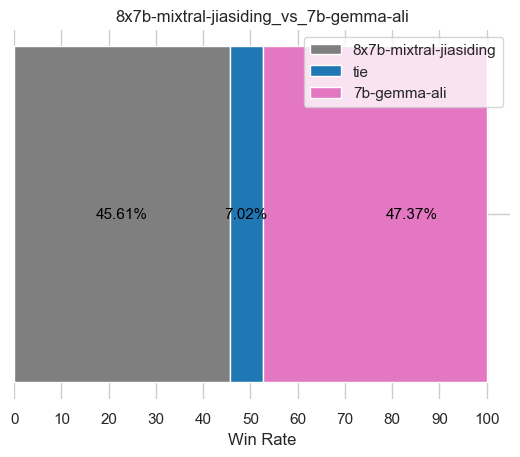

8x7b-mixtral-jiasiding vs. 7b-longqlora-axun: 获胜数为24，胜率为0.42105263157894735。
8x7b-mixtral-jiasiding vs. 7b-longqlora-axun: 平局数为2，平局率为0.03508771929824561。



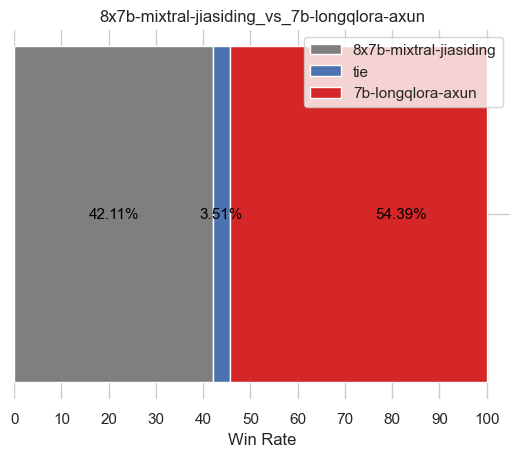

8x7b-mixtral-jiasiding vs. 13b-longqlora-axun: 获胜数为26，胜率为0.45614035087719296。
8x7b-mixtral-jiasiding vs. 13b-longqlora-axun: 平局数为2，平局率为0.03508771929824561。



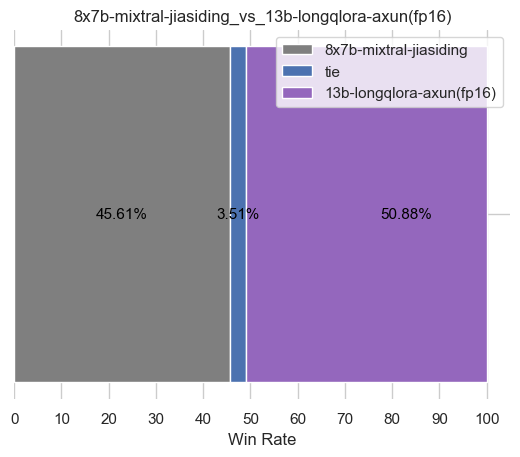

8x7b-mixtral-jiasiding vs. gpt35-ft-1pct: 获胜数为30，胜率为0.5263157894736842。
8x7b-mixtral-jiasiding vs. gpt35-ft-1pct: 平局数为5，平局率为0.08771929824561403。



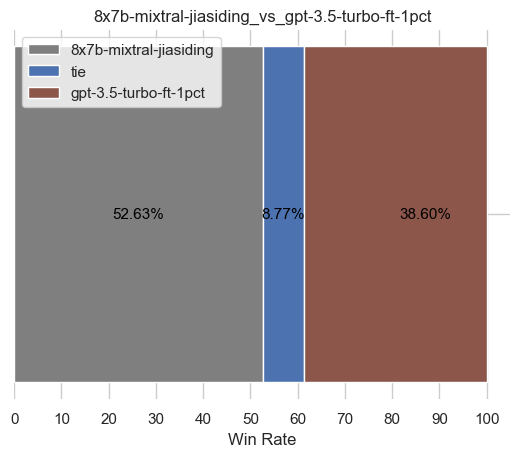

8x7b-mixtral-jiasiding vs. gpt35: 获胜数为48，胜率为0.8421052631578947。
8x7b-mixtral-jiasiding vs. gpt35: 平局数为1，平局率为0.017543859649122806。



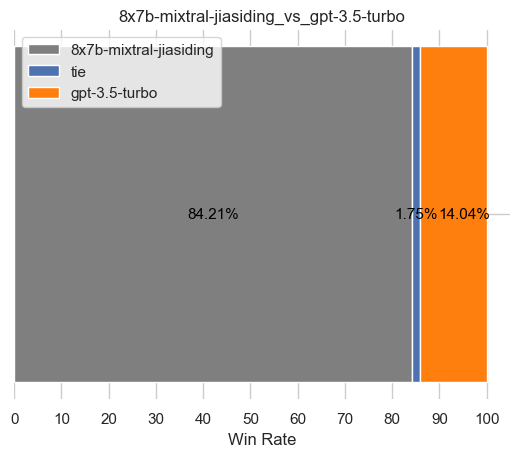

8x7b-mixtral-jiasiding vs. gpt4-1106: 获胜数为36，胜率为0.631578947368421。
8x7b-mixtral-jiasiding vs. gpt4-1106: 平局数为6，平局率为0.10526315789473684。



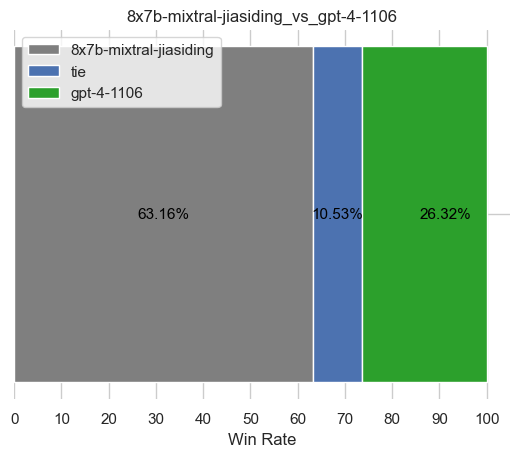

In [11]:
calculating(anchor= "8x7b-mixtral-jiasiding",
            others=["7b-gemma-ali","7b-longqlora-axun","13b-longqlora-axun", "gpt35-ft-1pct", "gpt35", "gpt4-1106"], 
            mapping=mapping,
            dataframe=df,
            mode="nums")

7b-gemma-ali vs. 8x7b-mixtral-jiasiding: 获胜数为27，胜率为0.47368421052631576。
7b-gemma-ali vs. 8x7b-mixtral-jiasiding: 平局数为4，平局率为0.07017543859649122。



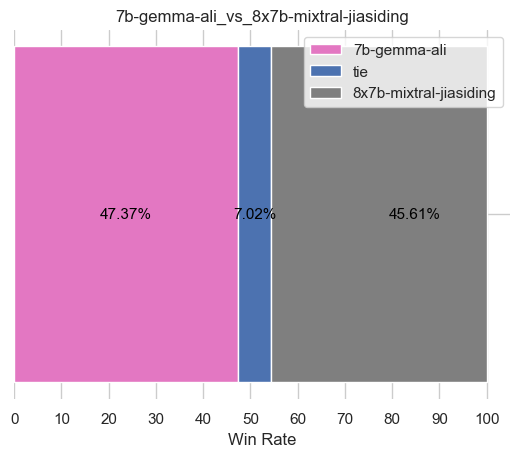

7b-gemma-ali vs. 7b-longqlora-axun: 获胜数为29，胜率为0.5087719298245614。
7b-gemma-ali vs. 7b-longqlora-axun: 平局数为6，平局率为0.10526315789473684。



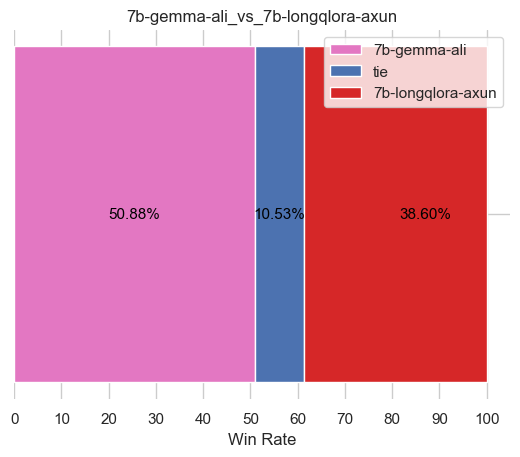

7b-gemma-ali vs. 13b-longqlora-axun: 获胜数为30，胜率为0.5263157894736842。
7b-gemma-ali vs. 13b-longqlora-axun: 平局数为6，平局率为0.10526315789473684。



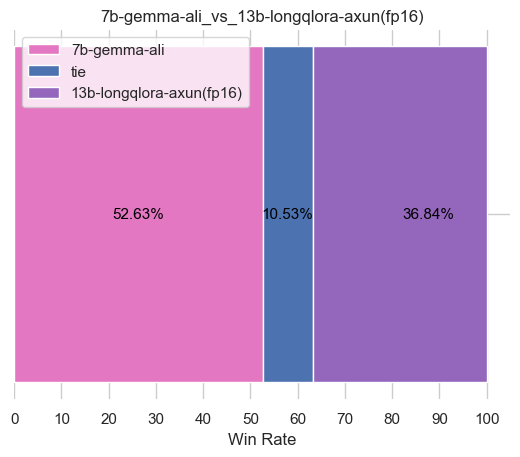

7b-gemma-ali vs. gpt35-ft-1pct: 获胜数为37，胜率为0.6491228070175439。
7b-gemma-ali vs. gpt35-ft-1pct: 平局数为3，平局率为0.05263157894736842。



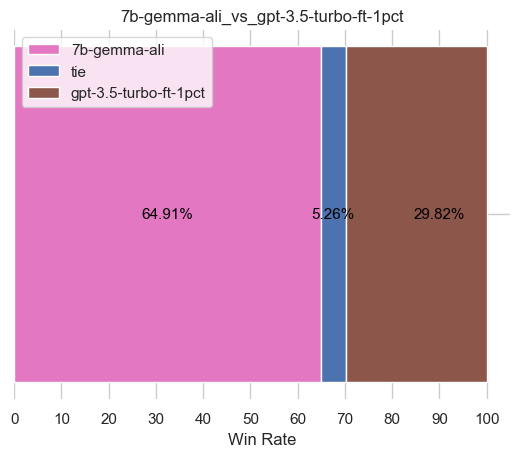

7b-gemma-ali vs. gpt35: 获胜数为55，胜率为0.9649122807017544。
7b-gemma-ali vs. gpt35: 平局数为1，平局率为0.017543859649122806。



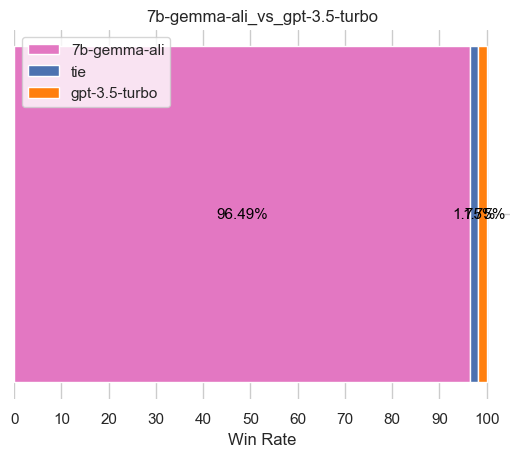

7b-gemma-ali vs. gpt4-1106: 获胜数为45，胜率为0.7894736842105263。
7b-gemma-ali vs. gpt4-1106: 平局数为3，平局率为0.05263157894736842。



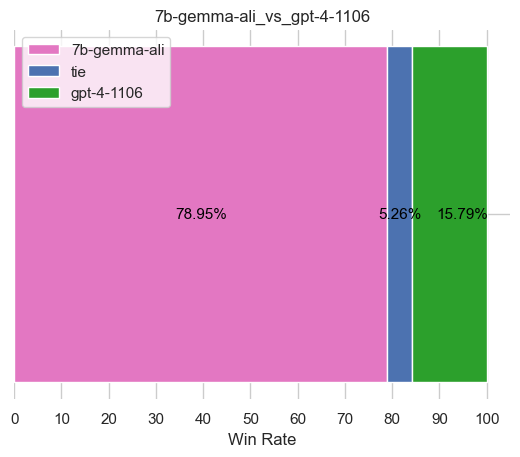

In [12]:
calculating(anchor= "7b-gemma-ali",
            others=["8x7b-mixtral-jiasiding","7b-longqlora-axun","13b-longqlora-axun", "gpt35-ft-1pct", "gpt35", "gpt4-1106"], 
            mapping=mapping,
            dataframe=df,
            mode="nums")

7b-longqlora-axun vs. 7b-gemma-ali: 获胜数为22，胜率为0.38596491228070173。
7b-longqlora-axun vs. 7b-gemma-ali: 平局数为6，平局率为0.10526315789473684。



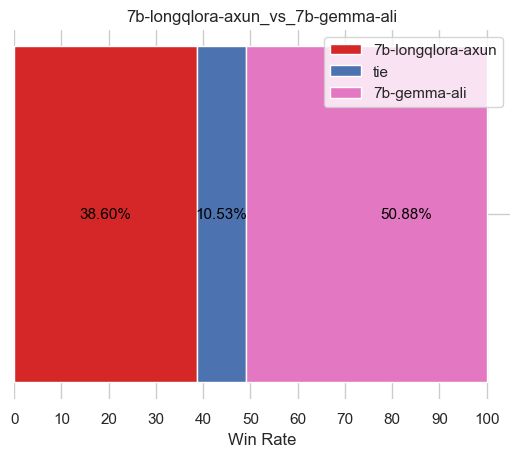

7b-longqlora-axun vs. 8x7b-mixtral-jiasiding: 获胜数为31，胜率为0.543859649122807。
7b-longqlora-axun vs. 8x7b-mixtral-jiasiding: 平局数为2，平局率为0.03508771929824561。



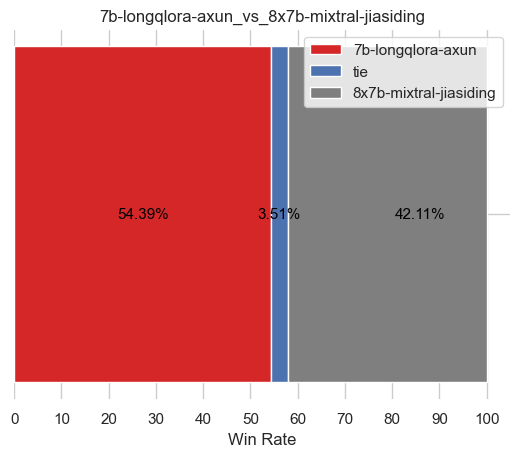

7b-longqlora-axun vs. 13b-longqlora-axun: 获胜数为27，胜率为0.47368421052631576。
7b-longqlora-axun vs. 13b-longqlora-axun: 平局数为6，平局率为0.10526315789473684。



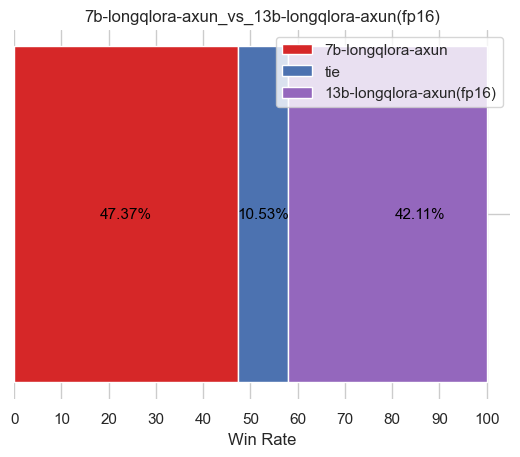

7b-longqlora-axun vs. gpt35-ft-1pct: 获胜数为35，胜率为0.6140350877192983。
7b-longqlora-axun vs. gpt35-ft-1pct: 平局数为2，平局率为0.03508771929824561。



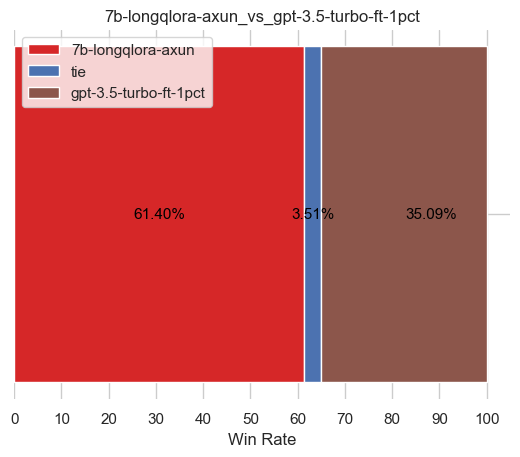

7b-longqlora-axun vs. gpt35: 获胜数为48，胜率为0.8421052631578947。
7b-longqlora-axun vs. gpt35: 平局数为4，平局率为0.07017543859649122。



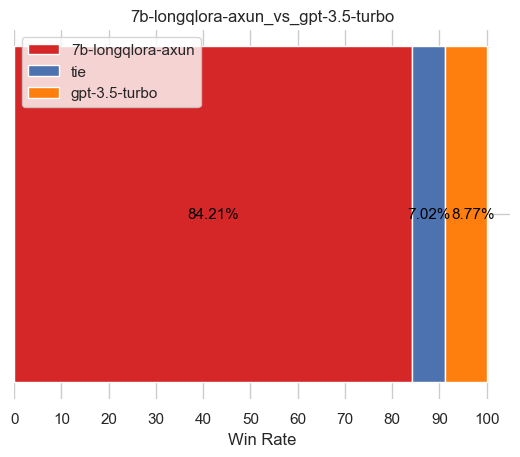

7b-longqlora-axun vs. gpt4-1106: 获胜数为36，胜率为0.631578947368421。
7b-longqlora-axun vs. gpt4-1106: 平局数为2，平局率为0.03508771929824561。



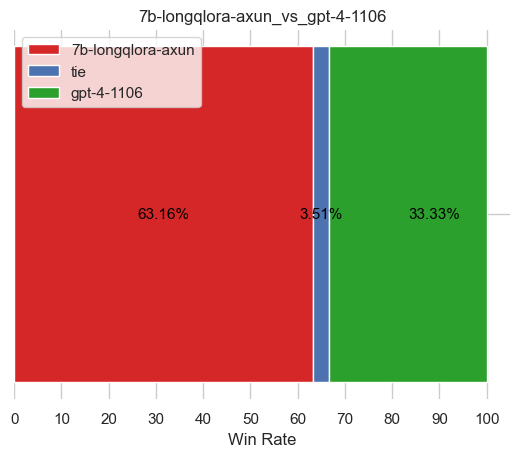

In [13]:
calculating(anchor= "7b-longqlora-axun",
            others=["7b-gemma-ali","8x7b-mixtral-jiasiding","13b-longqlora-axun", "gpt35-ft-1pct", "gpt35", "gpt4-1106"], 
            mapping=mapping,
            dataframe=df,
            mode="nums")

13b-longqlora-axun vs. 7b-gemma-ali: 获胜数为21，胜率为0.3684210526315789。
13b-longqlora-axun vs. 7b-gemma-ali: 平局数为6，平局率为0.10526315789473684。



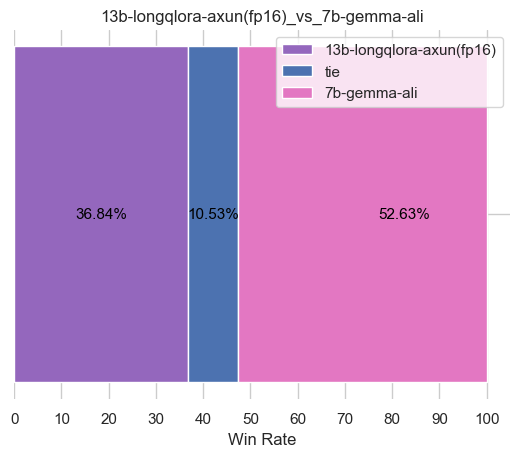

13b-longqlora-axun vs. 7b-longqlora-axun: 获胜数为24，胜率为0.42105263157894735。
13b-longqlora-axun vs. 7b-longqlora-axun: 平局数为6，平局率为0.10526315789473684。



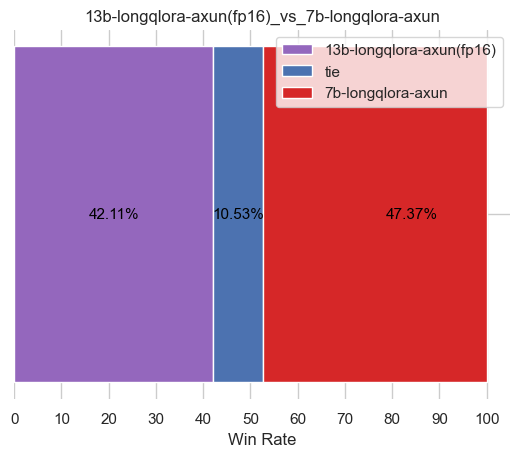

13b-longqlora-axun vs. 8x7b-mixtral-jiasiding: 获胜数为29，胜率为0.5087719298245614。
13b-longqlora-axun vs. 8x7b-mixtral-jiasiding: 平局数为2，平局率为0.03508771929824561。



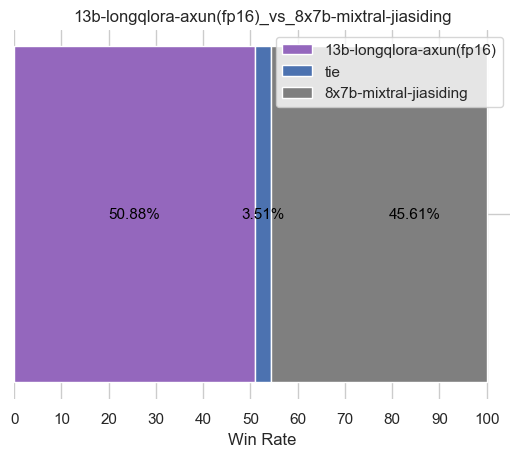

13b-longqlora-axun vs. gpt35-ft-1pct: 获胜数为35，胜率为0.6140350877192983。
13b-longqlora-axun vs. gpt35-ft-1pct: 平局数为6，平局率为0.10526315789473684。



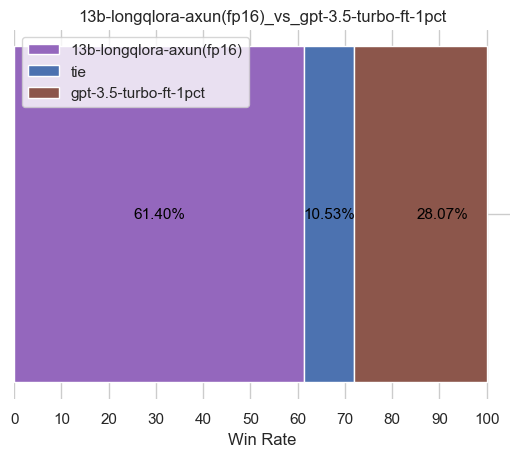

13b-longqlora-axun vs. gpt35: 获胜数为50，胜率为0.8771929824561403。
13b-longqlora-axun vs. gpt35: 平局数为3，平局率为0.05263157894736842。



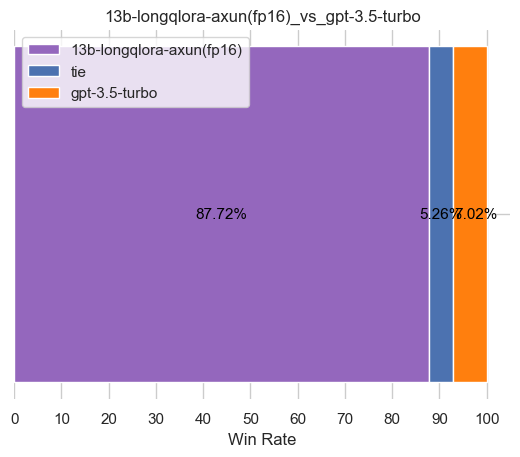

13b-longqlora-axun vs. gpt4-1106: 获胜数为43，胜率为0.7543859649122807。
13b-longqlora-axun vs. gpt4-1106: 平局数为0，平局率为0.0。



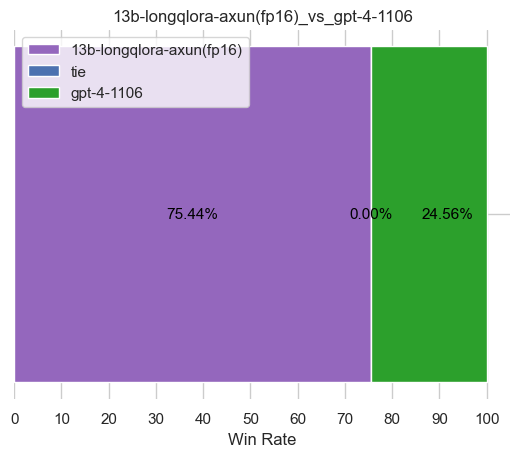

In [14]:
calculating(anchor= "13b-longqlora-axun",
            others=["7b-gemma-ali","7b-longqlora-axun","8x7b-mixtral-jiasiding", "gpt35-ft-1pct", "gpt35", "gpt4-1106"], 
            mapping=mapping,
            dataframe=df,
            mode="nums")

gpt35-ft-1pct vs. 7b-gemma-ali: 获胜数为17，胜率为0.2982456140350877。
gpt35-ft-1pct vs. 7b-gemma-ali: 平局数为3，平局率为0.05263157894736842。



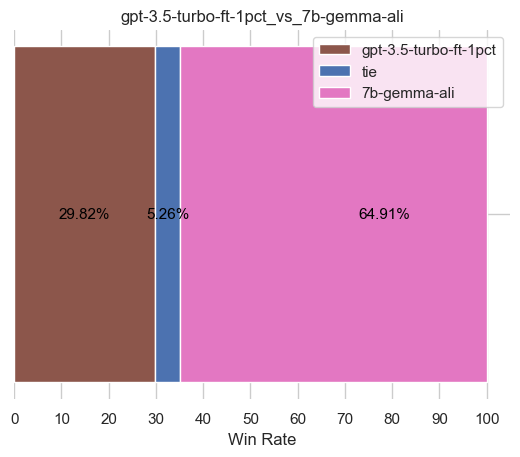

gpt35-ft-1pct vs. 7b-longqlora-axun: 获胜数为20，胜率为0.3508771929824561。
gpt35-ft-1pct vs. 7b-longqlora-axun: 平局数为2，平局率为0.03508771929824561。



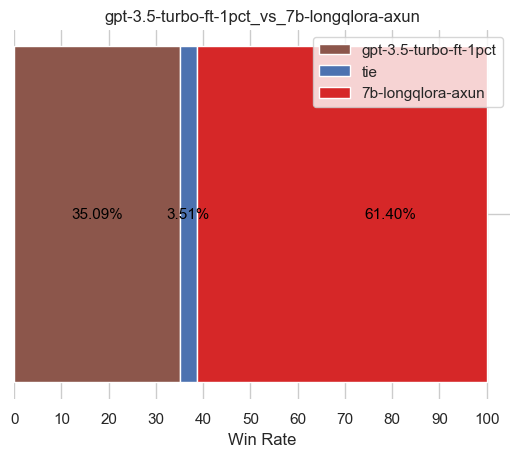

gpt35-ft-1pct vs. 13b-longqlora-axun: 获胜数为16，胜率为0.2807017543859649。
gpt35-ft-1pct vs. 13b-longqlora-axun: 平局数为6，平局率为0.10526315789473684。



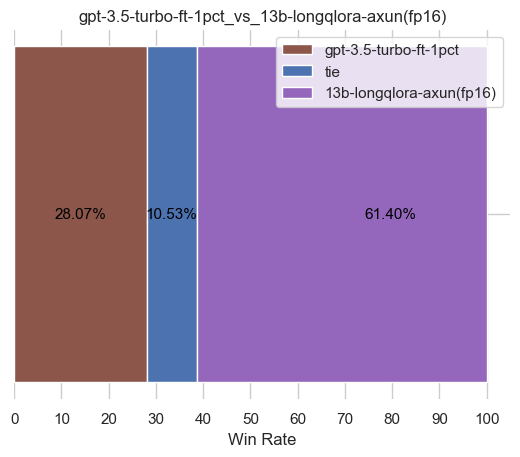

gpt35-ft-1pct vs. 8x7b-mixtral-jiasiding: 获胜数为22，胜率为0.38596491228070173。
gpt35-ft-1pct vs. 8x7b-mixtral-jiasiding: 平局数为5，平局率为0.08771929824561403。



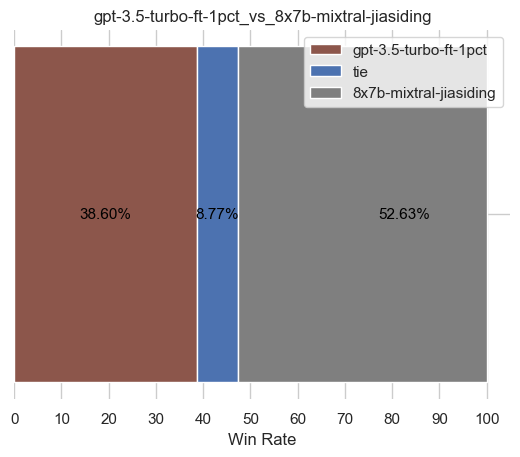

gpt35-ft-1pct vs. gpt35: 获胜数为49，胜率为0.8596491228070176。
gpt35-ft-1pct vs. gpt35: 平局数为1，平局率为0.017543859649122806。



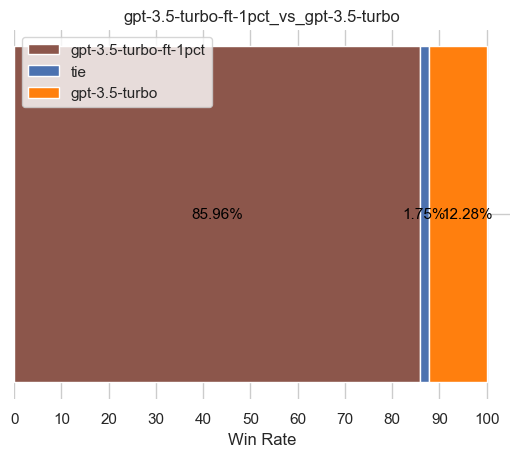

gpt35-ft-1pct vs. gpt4-1106: 获胜数为35，胜率为0.6140350877192983。
gpt35-ft-1pct vs. gpt4-1106: 平局数为3，平局率为0.05263157894736842。



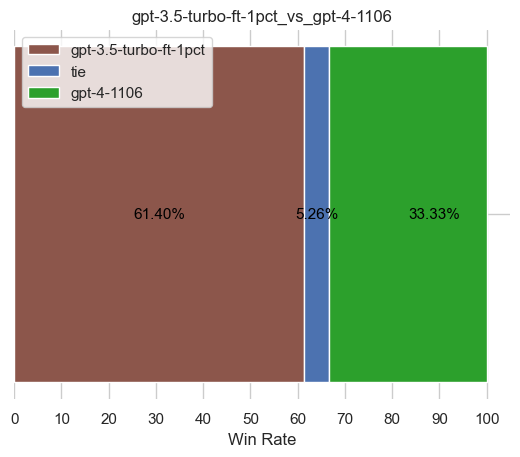

In [15]:
calculating(anchor= "gpt35-ft-1pct",
            others=["7b-gemma-ali","7b-longqlora-axun","13b-longqlora-axun", "8x7b-mixtral-jiasiding", "gpt35", "gpt4-1106"], 
            mapping=mapping,
            dataframe=df,
            mode="nums")

gpt35 vs. 7b-gemma-ali: 获胜数为1，胜率为0.017543859649122806。
gpt35 vs. 7b-gemma-ali: 平局数为1，平局率为0.017543859649122806。



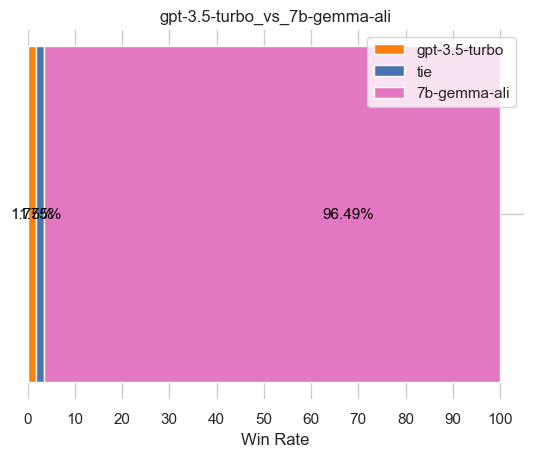

gpt35 vs. 7b-longqlora-axun: 获胜数为5，胜率为0.08771929824561403。
gpt35 vs. 7b-longqlora-axun: 平局数为4，平局率为0.07017543859649122。



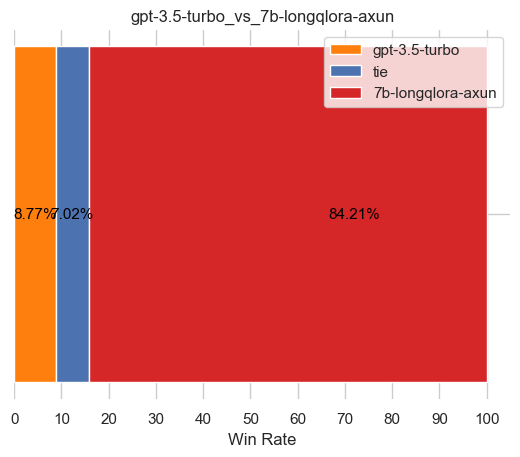

gpt35 vs. 13b-longqlora-axun: 获胜数为4，胜率为0.07017543859649122。
gpt35 vs. 13b-longqlora-axun: 平局数为3，平局率为0.05263157894736842。



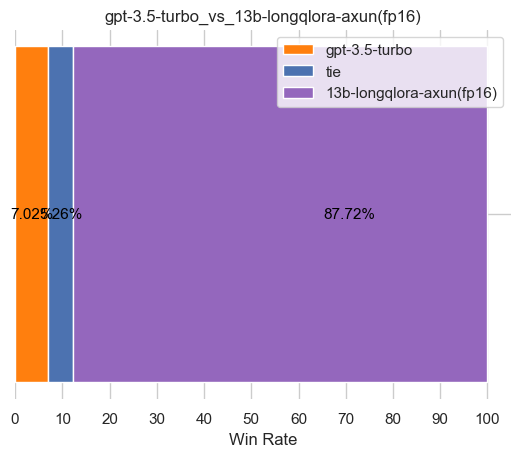

gpt35 vs. gpt35-ft-1pct: 获胜数为7，胜率为0.12280701754385964。
gpt35 vs. gpt35-ft-1pct: 平局数为1，平局率为0.017543859649122806。



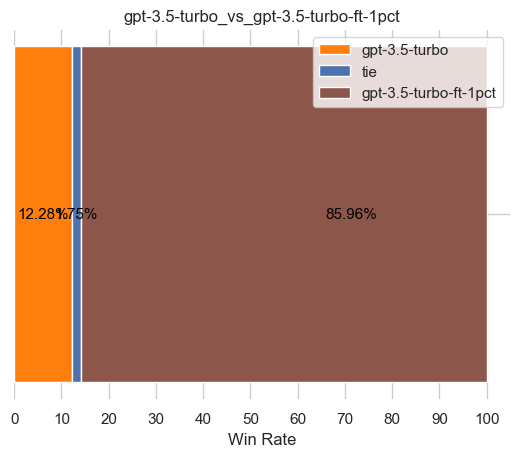

gpt35 vs. 8x7b-mixtral-jiasiding: 获胜数为8，胜率为0.14035087719298245。
gpt35 vs. 8x7b-mixtral-jiasiding: 平局数为1，平局率为0.017543859649122806。



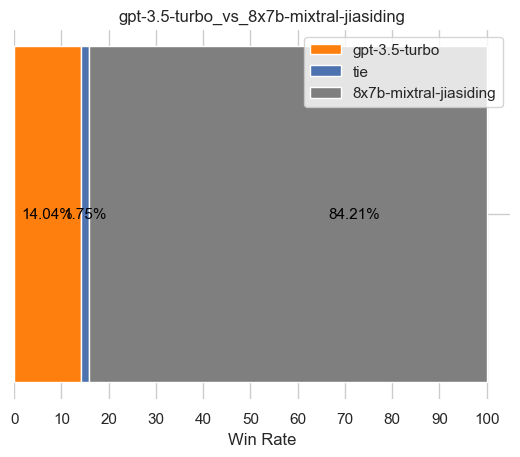

gpt35 vs. gpt4-1106: 获胜数为10，胜率为0.17543859649122806。
gpt35 vs. gpt4-1106: 平局数为4，平局率为0.07017543859649122。



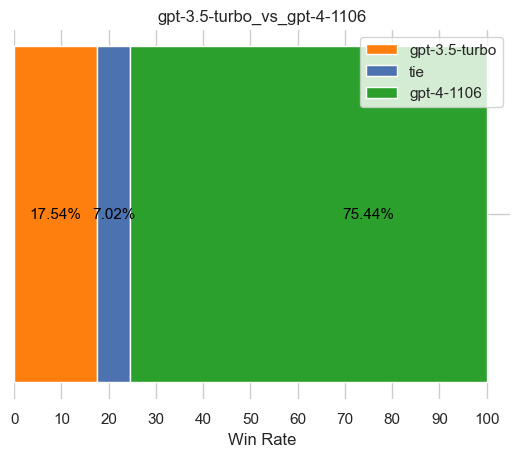

In [16]:
calculating(anchor= "gpt35",
            others=["7b-gemma-ali","7b-longqlora-axun","13b-longqlora-axun", "gpt35-ft-1pct", "8x7b-mixtral-jiasiding", "gpt4-1106"], 
            mapping=mapping,
            dataframe=df,
            mode="nums")

gpt4-1106 vs. 7b-gemma-ali: 获胜数为9，胜率为0.15789473684210525。
gpt4-1106 vs. 7b-gemma-ali: 平局数为3，平局率为0.05263157894736842。



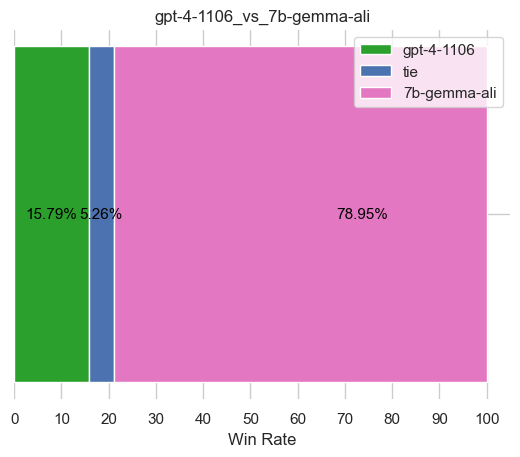

gpt4-1106 vs. 7b-longqlora-axun: 获胜数为19，胜率为0.3333333333333333。
gpt4-1106 vs. 7b-longqlora-axun: 平局数为2，平局率为0.03508771929824561。



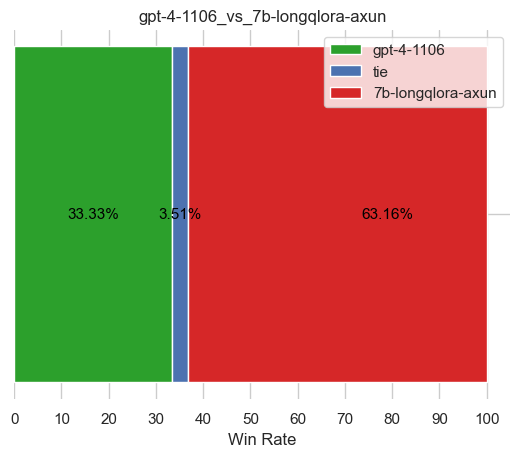

gpt4-1106 vs. 13b-longqlora-axun: 获胜数为14，胜率为0.24561403508771928。
gpt4-1106 vs. 13b-longqlora-axun: 平局数为0，平局率为0.0。



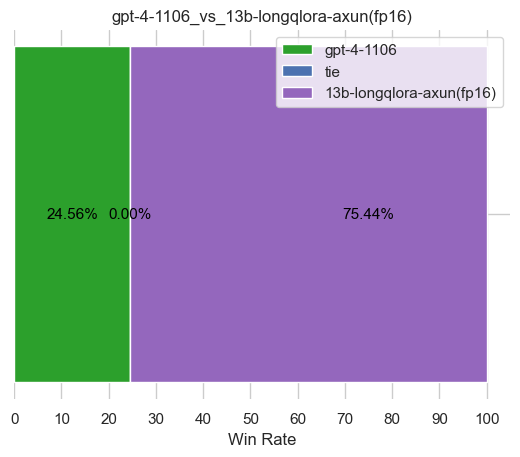

gpt4-1106 vs. gpt35-ft-1pct: 获胜数为19，胜率为0.3333333333333333。
gpt4-1106 vs. gpt35-ft-1pct: 平局数为3，平局率为0.05263157894736842。



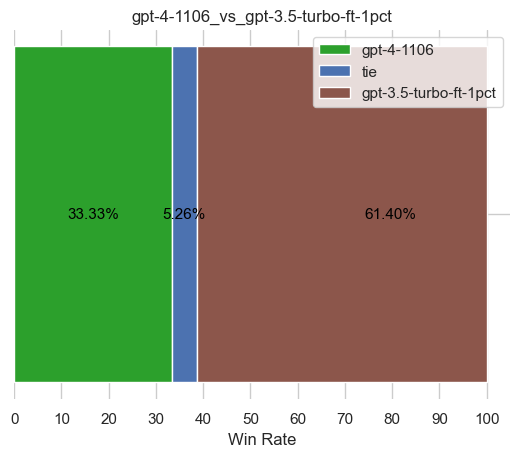

gpt4-1106 vs. gpt35: 获胜数为43，胜率为0.7543859649122807。
gpt4-1106 vs. gpt35: 平局数为4，平局率为0.07017543859649122。



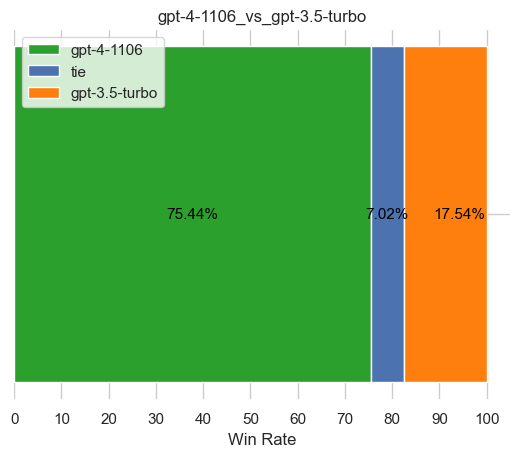

gpt4-1106 vs. 8x7b-mixtral-jiasiding: 获胜数为15，胜率为0.2631578947368421。
gpt4-1106 vs. 8x7b-mixtral-jiasiding: 平局数为6，平局率为0.10526315789473684。



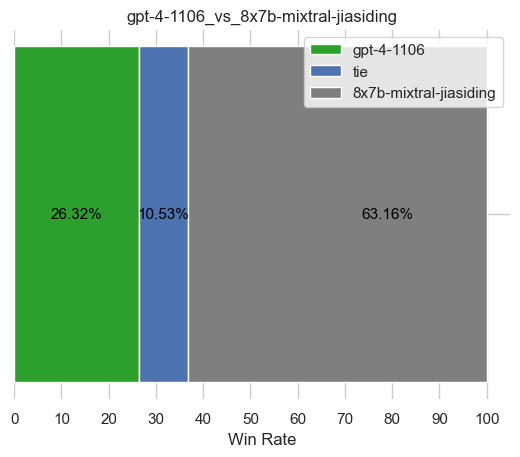

In [17]:
calculating(anchor= "gpt4-1106",
            others=["7b-gemma-ali","7b-longqlora-axun","13b-longqlora-axun", "gpt35-ft-1pct", "gpt35", "8x7b-mixtral-jiasiding"], 
            mapping=mapping,
            dataframe=df,
            mode="nums")